In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_colwidth", 1000)


### Reading the dataset


In [2]:
import os
import re
import json

data_path = 'data'
conversations = [
    'conversations-part1', 
    'conversations-part2',
    'conversations-part3',
]

dfs = []
total_number_of_conversations = sum(
    [len(os.listdir(os.path.join(data_path, conversation))) 
     for conversation in conversations])
number_of_conversations = 0
increment = 0

for conversation in conversations:
    path = os.path.join(data_path, conversation)
    for f in os.listdir(path):
        
        percent = (
            (number_of_conversations/total_number_of_conversations)*100
        )
        
        if percent/10 >= increment:
            print(f'{increment*10}% processed.')
            increment += 1
        
        true_path = os.path.join(path, f)
        
        c_df = pd.read_json(true_path, lines=True)
        c_id = re.search('([0-9]+)', f).group(0)
        c_thread = []
        for t, c in zip(c_df['toxicity'], c_df['cleaned_content']):
            c_thread.append((float(t), str(c)))
        
        df = pd.DataFrame({'id': c_id, 'thread': c_thread})
        dfs.append(df)
        
        number_of_conversations += 1

full_wikipedia_df = pd.concat(dfs)
full_wikipedia_df = full_wikipedia_df.groupby(['id'])['thread'].apply(list).reset_index()
# sample .1 of the datasets
wikipedia_df = full_wikipedia_df.sample(frac=.1)

0% processed.
10% processed.
20% processed.
30% processed.
40% processed.
50% processed.
60% processed.
70% processed.
80% processed.
90% processed.


In [3]:
# sample 50% of the dataset
wikipedia_df = full_wikipedia_df.sample(frac=.5)

In [4]:
print(wikipedia_df.shape)
wikipedia_df.head()

(96634, 2)


,id,thread
99064,383017989,"[(0.1134071, Sorting by language rather than by country ), (0.05908121, It seems rather strange to me that the different sections are named and sorted by country. More often than not, notation and pronunciation of times is tied to the language, not to the country. Differences in customs between two countries speaking the same language are usually much smaller than those between two different languages (whether in the same country or not). Case in point would be the usage in East Africa, which is strongly language-dependent as is mentioned in the article. So I think the article should sort by language, and subsections should be created where norms differ in different countries speaking the same language (i.e. English in the UK versus English in the US). ), (0.0440167, ""More often than not, notation and pronunciation of times is tied to the language."" Are you sure? What is your evidence for that? I would rather guess the opposite, since formats are often standardized by the STATE b..."
192042,96771021,"[(0.04421617, History of the States of Jersey ), (0.05053069, Have added in the History of the States of Jersey from its origins as a small part of the Royal Court, don't think the history section as it was really did it's job!\nI have taken out certain further sections relating to specific politicians and their activities outside the States of Jersey. Hope this is an improvement.), (0.05941844, Have added in the History of the States of Jersey from its origins as a small part of the Royal Court, don't think the history section as it was really did it's job!\nI have taken out certain further sections relating to specific politicians and their activities outside the States of Jersey. Hope this is an improvement.\nDarius)]"
108179,414654877,"[(0.01145369, Vegas ), (0.06575359, Guys, the source which adds Cunningham's limited schedule mentioned Vegas, thus adding Vegas makes sense, seeing as there's nothing saying to the contrary as of yet? Several other sites which report on it also mention Vegas as well - although while that may be simply as they all reported from a press release, it still shows that they know something that probably hasn't yet been publicly announced for a reason. '''''' •), (0.04667206, There are speculations about Las Vegas for a long time. But we have to wait until an official announcement is made. There would be a reason why here stand TBA on October 16. ), (0.0581587, I'm well aware that it has officially been TBA since the announcement of the schedule last year. However, as it stands, this is the first source which has concretely mentioned anything with regards to the eventual decision as to whether it is Vegas or California. Another thing to note is that the report doesn't even have a hint o..."
637,101729823,"[(0.01805616, language articles), (0.03854093, 'nuff said, but can be titled either in native language (St'at'imcets) or in the form Shuswap language; Wiki guidelines, it should be stressed, prefer the latter (use English, which is the language of the encyclopedia...). Some ethno and gov articles will have more than one language listed in their cats; some languages span more than one gov group, or in the case of the Sto:lo and Chehalis, two different ones. Cats for this are specialized in the linguistics hierarchy (examples later), but they should generally all take the relevant nation-category if there is one Category:Secwepemc, Category:Stó:lō, Category:Syilx etc.), (0.03854093, 'nuff said, but can be titled either in native language (St'at'imcets) or in the form Shuswap language; Wiki guidelines, it should be stressed, prefer the latter (use English, which is the language of the encyclopedia...). Some ethno and gov articles will have more than one language listed in their cat..."
174752,672352256,"[(0.0401642, ), (0.08465946, Templates like these should not be viewable to the reader. Example templates are , and . You will also need to add a date parameter, a category a

### Building the comment threads at each comment level in the dataset


In [5]:
import string
import contractions
import re

from nltk.tokenize import word_tokenize
from num2words import num2words

def numbers_to_words(text: str) -> str:
    t = text.split()
    for ind, word in enumerate(t):
        if all(c.isdigit() for c in word):
            t[ind] = num2words(word)
        elif (
            len(word) > 2
            and all(c.isdigit() for c in word[:-2])
            and word[-2:] in ["st", "nd", "rd", "th"]
        ):
            t[ind] = num2words(int(word[:-2]), to="ordinal")

    return " ".join(t)

grouped_threads = []

for thread in wikipedia_df["thread"]:
    grouped_comments = []
    
    for comment in thread:
        
        stripped_comment = str(comment[1]).strip().lower()
        no_http_comment = re.sub(r'\s*https?://\S+(\s+|$)', '', stripped_comment)        
        alphabetical_comment = re.sub(r'[^a-zA-Z\s+]', '', no_http_comment)
        whitespaced_comment = re.sub(r'\s\s+/g', ' ', alphabetical_comment)
        expanded_comment = contractions.fix(whitespaced_comment)
        tokenized_comment = word_tokenize(expanded_comment)
            
        grouped_comments.append(' '.join(tokenized_comment) + '.')

    grouped_threads.append(' '.join(grouped_comments))

wikipedia_df['text'] = grouped_threads

def calculate_overall_toxicity_boolean(thread):
    if not thread: return 0
    return sum([comment[0] for comment in thread])/len(thread) > .5

def calculate_overall_toxicity_continuous(thread):
    if not thread: return 0
    return sum([comment[0] for comment in thread])/len(thread)

wikipedia_df['toxicity_bool'] = [calculate_overall_toxicity_boolean(thread) 
                                 for thread in wikipedia_df['thread']]

wikipedia_df['toxicity_cont'] = [calculate_overall_toxicity_continuous(thread) 
                                 for thread in wikipedia_df['thread']]

### Splitting the dataset


In [6]:
df = wikipedia_df[['toxicity_bool', 'toxicity_cont', 'text']]

yes_toxic = df[df['toxicity_bool'] == 1].sample(2_000)
no_toxic = df[df['toxicity_bool'] == 0].sample(2_000)
balanced_df = pd.concat([yes_toxic, no_toxic])

train_df = balanced_df.sample(frac=0.6, random_state=200)
dev_df = balanced_df.drop(train_df.index).sample(frac=.5)
test_df = balanced_df.drop(train_df.index).drop(dev_df.index)

### Visualizing the dataset


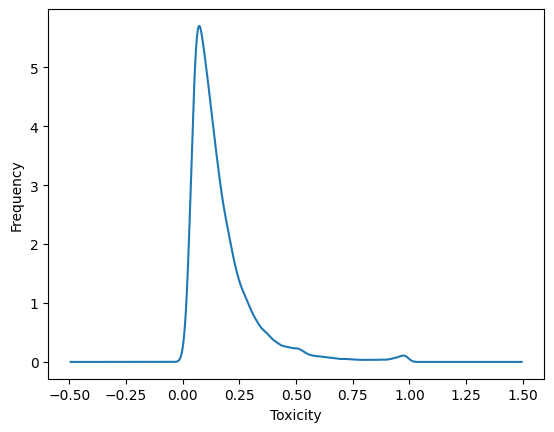

In [7]:
cols = [
    ["toxicity_cont", "Toxicity"]
]

for column_name, display_name in cols:
    s = pd.Series(wikipedia_df[column_name])
    ax = s.plot.density()
    ax.set(ylabel="Frequency", xlabel=display_name)

plt.show()

### Baseline Model


In [8]:
import gensim
import gensim.downloader as api
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score


In [9]:
for df in [train_df, dev_df, test_df]:
    df['toxicity'] = df['toxicity_bool']

In [10]:
w2v_model = api.load("word2vec-google-news-300")

In [11]:
def get_average_w2v_vector(row):
    words = row["text"].split()

    avg_text_w2v = np.sum([w2v_model[w] for w in words if w in w2v_model], axis=0) / (
        len(words) if words else 1
    )

    if avg_text_w2v.shape != (300,):
        avg_text_w2v = np.zeros((300,))

    return avg_text_w2v


baseline_scores = pd.DataFrame(columns=["Dataset", "Dev F1", "Test F1"])

for target_col, display_name in [
    ("toxicity", "Toxicity"),
]:
    train_X = train_df.apply(
        lambda x: get_average_w2v_vector(x), axis=1, result_type="expand"
    )
    dev_X = dev_df.apply(
        lambda x: get_average_w2v_vector(x), axis=1, result_type="expand"
    )
    test_X = test_df.apply(
        lambda x: get_average_w2v_vector(x), axis=1, result_type="expand"
    )

    train_y = train_df[target_col]
    dev_y = dev_df[target_col]
    test_y = test_df[target_col]

    train_X = train_X[train_y.notna()]
    train_y = train_y[train_y.notna()]

    dev_X = dev_X[dev_y.notna()]
    dev_y = dev_y[dev_y.notna()]

    test_X = test_X[test_y.notna()]
    test_y = test_y[test_y.notna()]

    clf = LogisticRegression(max_iter=10000)
    clf.fit(train_X, train_y)

    pred_dev_y = clf.predict(dev_X)
    pred_test_y = clf.predict(test_X)

    baseline_scores.loc[len(baseline_scores.index)] = [
        display_name,
        f1_score(dev_y, pred_dev_y, average="weighted"),
        f1_score(test_y, pred_test_y, average="weighted"),
    ]


baseline_scores.round(2)


,Dataset,Dev F1,Test F1
0,Toxicity,0.86,0.88


### Baseline Model with Extractive Summary Features


In [12]:
from sumy.nlp.stemmers import Stemmer
from sumy.nlp.tokenizers import Tokenizer
from sumy.parsers.plaintext import PlaintextParser
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.summarizers.lsa import LsaSummarizer
from sumy.summarizers.luhn import LuhnSummarizer
from sumy.summarizers.text_rank import TextRankSummarizer


In [13]:
class Summarizer:
    def __init__(self) -> None:
        self.language = "english"
        self.num_sentences = 3
        self.tokenizer = Tokenizer(self.language)
        self.stemmer = Stemmer(self.language)

    def summarize(self, thread: str) -> str:
        parser = PlaintextParser.from_string(thread, self.tokenizer)
        return "".join(
            (x._text for x in self.summarizer(parser.document, self.num_sentences))
        )


class Luhn(Summarizer):
    def __init__(self) -> None:
        super().__init__()
        self.summarizer = LuhnSummarizer()

    def __str__(self):
        return "Luhn"


class LSA(Summarizer):
    def __init__(self) -> None:
        super().__init__()
        self.summarizer = LsaSummarizer()

    def __str__(self):
        return "LSA"


class LexRank(Summarizer):
    def __init__(self) -> None:
        super().__init__()
        self.summarizer = LexRankSummarizer()

    def __str__(self):
        return "LexRank"


class TextRank(Summarizer):
    def __init__(self) -> None:
        super().__init__()
        self.summarizer = TextRankSummarizer()

    def __str__(self):
        return "TextRank"


summarizer_models = [Luhn(), LSA(), LexRank(), TextRank()]


Bag of Words

In [14]:
baseline_scores = pd.DataFrame(columns=["Summarizer", "Target", "Dev F1", "Test F1"])


for summarizer in summarizer_models:
    train_df["summary"] = train_df["text"].apply(summarizer.summarize)
    dev_df["summary"] = dev_df["text"].apply(summarizer.summarize)
    test_df["summary"] = test_df["text"].apply(summarizer.summarize)

    for target_col, display_name in [
        ("toxicity", "Toxicity"),
    ]:


        vectorizer = CountVectorizer()
        train_X = vectorizer.fit_transform(train_df["summary"])
        dev_X = vectorizer.transform(dev_df["summary"])
        test_X = vectorizer.transform(test_df["summary"])

        train_y = train_df[target_col]
        dev_y = dev_df[target_col]
        test_y = test_df[target_col]

        train_X = train_X[train_y.notna()]
        train_y = train_y[train_y.notna()]

        dev_X = dev_X[dev_y.notna()]
        dev_y = dev_y[dev_y.notna()]

        test_X = test_X[test_y.notna()]
        test_y = test_y[test_y.notna()]

        clf = LogisticRegression(max_iter=10000)
        clf.fit(train_X, train_y)

        pred_dev_y = clf.predict(dev_X)
        pred_test_y = clf.predict(test_X)

        baseline_scores.loc[len(baseline_scores.index)] = [
            str(summarizer),
            display_name,
            f1_score(dev_y, pred_dev_y, average="weighted"),
            f1_score(test_y, pred_test_y, average="weighted"),
        ]

    train_df = train_df.drop(["summary"], axis=1)
    dev_df = dev_df.drop(["summary"], axis=1)
    test_df = test_df.drop(["summary"], axis=1)


baseline_scores.round(2)

/opt/homebrew/lib/python3.10/site-packages/sumy/summarizers/lsa.py:76: UserWarning: Number of words (6) is lower than number of sentences (839). LSA algorithm may not work properly.
  warn(message % (words_count, sentences_count))
/opt/homebrew/lib/python3.10/site-packages/sumy/summarizers/lsa.py:76: UserWarning: Number of words (4) is lower than number of sentences (6). LSA algorithm may not work properly.
  warn(message % (words_count, sentences_count))
/opt/homebrew/lib/python3.10/site-packages/sumy/summarizers/lsa.py:76: UserWarning: Number of words (3) is lower than number of sentences (4). LSA algorithm may not work properly.
  warn(message % (words_count, sentences_count))
/opt/homebrew/lib/python3.10/site-packages/sumy/summarizers/lsa.py:76: UserWarning: Number of words (1) is lower than number of sentences (2). LSA algorithm may not work properly.
  warn(message % (words_count, sentences_count))


,Summarizer,Target,Dev F1,Test F1
0,Luhn,Toxicity,0.84,0.86
1,LSA,Toxicity,0.85,0.86
2,LexRank,Toxicity,0.84,0.85
3,TextRank,Toxicity,0.85,0.85


TF-IDF

In [15]:
baseline_scores = pd.DataFrame(columns=["Summarizer", "Target", "Dev F1", "Test F1"])


for summarizer in summarizer_models:
    train_df["summary"] = train_df["text"].apply(summarizer.summarize)
    dev_df["summary"] = dev_df["text"].apply(summarizer.summarize)
    test_df["summary"] = test_df["text"].apply(summarizer.summarize)

    for target_col, display_name in [
        ("toxicity", "Toxicity"),
    ]:


        vectorizer = TfidfVectorizer()
        train_X = vectorizer.fit_transform(train_df["summary"])
        dev_X = vectorizer.transform(dev_df["summary"])
        test_X = vectorizer.transform(test_df["summary"])

        train_y = train_df[target_col]
        dev_y = dev_df[target_col]
        test_y = test_df[target_col]

        train_X = train_X[train_y.notna()]
        train_y = train_y[train_y.notna()]

        dev_X = dev_X[dev_y.notna()]
        dev_y = dev_y[dev_y.notna()]

        test_X = test_X[test_y.notna()]
        test_y = test_y[test_y.notna()]

        clf = LogisticRegression(max_iter=10000)
        clf.fit(train_X, train_y)

        pred_dev_y = clf.predict(dev_X)
        pred_test_y = clf.predict(test_X)

        baseline_scores.loc[len(baseline_scores.index)] = [
            str(summarizer),
            display_name,
            f1_score(dev_y, pred_dev_y, average="weighted"),
            f1_score(test_y, pred_test_y, average="weighted"),
        ]

    train_df = train_df.drop(["summary"], axis=1)
    dev_df = dev_df.drop(["summary"], axis=1)
    test_df = test_df.drop(["summary"], axis=1)


baseline_scores.round(2)

/opt/homebrew/lib/python3.10/site-packages/sumy/summarizers/lsa.py:76: UserWarning: Number of words (6) is lower than number of sentences (839). LSA algorithm may not work properly.
  warn(message % (words_count, sentences_count))
/opt/homebrew/lib/python3.10/site-packages/sumy/summarizers/lsa.py:76: UserWarning: Number of words (4) is lower than number of sentences (6). LSA algorithm may not work properly.
  warn(message % (words_count, sentences_count))
/opt/homebrew/lib/python3.10/site-packages/sumy/summarizers/lsa.py:76: UserWarning: Number of words (3) is lower than number of sentences (4). LSA algorithm may not work properly.
  warn(message % (words_count, sentences_count))
/opt/homebrew/lib/python3.10/site-packages/sumy/summarizers/lsa.py:76: UserWarning: Number of words (1) is lower than number of sentences (2). LSA algorithm may not work properly.
  warn(message % (words_count, sentences_count))


,Summarizer,Target,Dev F1,Test F1
0,Luhn,Toxicity,0.85,0.86
1,LSA,Toxicity,0.85,0.86
2,LexRank,Toxicity,0.86,0.85
3,TextRank,Toxicity,0.85,0.86


Word2Vec

In [16]:
def get_average_w2v_vector_thread(row):
    words = row["text"].split()
    summary_words = row["summary"].split()

    avg_text_w2v = np.sum([w2v_model[w] for w in words if w in w2v_model], axis=0) / (
        len(words) if words else 1
    )

    if avg_text_w2v.shape != (300,):
        avg_text_w2v = np.zeros((300,))

    avg_thread_w2v = np.sum(
        [w2v_model[w] for w in summary_words if w in w2v_model], axis=0
    ) / (len(summary_words) if summary_words else 1)

    if avg_thread_w2v.shape != (300,):
        avg_thread_w2v = np.zeros((300,))

    embedding = np.concatenate((avg_text_w2v, avg_thread_w2v), axis=None)
    return embedding


baseline_scores = pd.DataFrame(columns=["Summarizer", "Target", "Dev F1", "Test F1"])


for summarizer in summarizer_models:
    train_df["summary"] = train_df["text"].apply(summarizer.summarize)
    dev_df["summary"] = dev_df["text"].apply(summarizer.summarize)
    test_df["summary"] = test_df["text"].apply(summarizer.summarize)

    for target_col, display_name in [
        ("toxicity", "Toxicity"),
    ]:
        train_X = train_df.apply(
            lambda x: get_average_w2v_vector_thread(x), axis=1, result_type="expand"
        )
        dev_X = dev_df.apply(
            lambda x: get_average_w2v_vector_thread(x), axis=1, result_type="expand"
        )
        test_X = test_df.apply(
            lambda x: get_average_w2v_vector_thread(x), axis=1, result_type="expand"
        )

        train_y = train_df[target_col]
        dev_y = dev_df[target_col]
        test_y = test_df[target_col]

        train_X = train_X[train_y.notna()]
        train_y = train_y[train_y.notna()]

        dev_X = dev_X[dev_y.notna()]
        dev_y = dev_y[dev_y.notna()]

        test_X = test_X[test_y.notna()]
        test_y = test_y[test_y.notna()]

        clf = LogisticRegression(max_iter=10000)
        clf.fit(train_X, train_y)

        pred_dev_y = clf.predict(dev_X)
        pred_test_y = clf.predict(test_X)

        baseline_scores.loc[len(baseline_scores.index)] = [
            str(summarizer),
            display_name,
            f1_score(dev_y, pred_dev_y, average="weighted"),
            f1_score(test_y, pred_test_y, average="weighted"),
        ]

    train_df = train_df.drop(["summary"], axis=1)
    dev_df = dev_df.drop(["summary"], axis=1)
    test_df = test_df.drop(["summary"], axis=1)


baseline_scores.round(2)


/opt/homebrew/lib/python3.10/site-packages/sumy/summarizers/lsa.py:76: UserWarning: Number of words (6) is lower than number of sentences (839). LSA algorithm may not work properly.
  warn(message % (words_count, sentences_count))
/opt/homebrew/lib/python3.10/site-packages/sumy/summarizers/lsa.py:76: UserWarning: Number of words (4) is lower than number of sentences (6). LSA algorithm may not work properly.
  warn(message % (words_count, sentences_count))
/opt/homebrew/lib/python3.10/site-packages/sumy/summarizers/lsa.py:76: UserWarning: Number of words (3) is lower than number of sentences (4). LSA algorithm may not work properly.
  warn(message % (words_count, sentences_count))
/opt/homebrew/lib/python3.10/site-packages/sumy/summarizers/lsa.py:76: UserWarning: Number of words (1) is lower than number of sentences (2). LSA algorithm may not work properly.
  warn(message % (words_count, sentences_count))


,Summarizer,Target,Dev F1,Test F1
0,Luhn,Toxicity,0.86,0.88
1,LSA,Toxicity,0.87,0.89
2,LexRank,Toxicity,0.87,0.89
3,TextRank,Toxicity,0.86,0.88


### Models with sentence embedding features


In [18]:
%pip install sentence-transformers

from sentence_transformers import SentenceTransformer

sbert_model = SentenceTransformer("stsb-distilroberta-base-v2")

train_sentence_embeddings = {}
dev_entence_embeddings = {}
test_sentence_embeddings = {}

train_sentence_embeddings["Base"] = sbert_model.encode(train_df["text"].to_list())
dev_entence_embeddings["Base"] = sbert_model.encode(dev_df["text"].to_list())
test_sentence_embeddings["Base"] = sbert_model.encode(test_df["text"].to_list())


  Using cached sentence-transformers-2.2.2.tar.gz (85 kB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 1.1 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 MB 2.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 1.2 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 2.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 kB 2.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.0/174.0 kB 387.4 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 916.8 kB/s eta 0:00:0000:0100:01m
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125925 sha256=c92beea48b2e9282e011918d75afe9f23c7b9f1fe23d7edc2b5c8cb12a94fe8a
  Stored in directory: /Users/kevinsun/Library/Caches/pip/wheels/62/f2/10/1e606fd5f02395388f

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
for summarizer in summarizer_models:
    train_sentence_embeddings[str(summarizer)] = sbert_model.encode(
        train_df["text"].apply(summarizer.summarize).to_list()
    )
    dev_entence_embeddings[str(summarizer)] = sbert_model.encode(
        dev_df["text"].apply(summarizer.summarize).to_list()
    )
    test_sentence_embeddings[str(summarizer)] = sbert_model.encode(
        test_df["text"].apply(summarizer.summarize).to_list()
    )


In [ ]:
baseline_scores = pd.DataFrame(columns=["Dataset", "Dev F1", "Test F1"])


for target_col, display_name in [
    ("toxicity", "Toxicity"),
]:
    train_X = train_sentence_embeddings["Base"].copy()
    dev_X = dev_entence_embeddings["Base"].copy()
    test_X = test_sentence_embeddings["Base"].copy()

    train_y = train_df[target_col]
    dev_y = dev_df[target_col]
    test_y = test_df[target_col]

    train_X = train_X[train_y.notna()]
    train_y = train_y[train_y.notna()]

    dev_X = dev_X[dev_y.notna()]
    dev_y = dev_y[dev_y.notna()]

    test_X = test_X[test_y.notna()]
    test_y = test_y[test_y.notna()]

    clf = LogisticRegression(max_iter=10000)
    clf.fit(train_X, train_y)

    pred_dev_y = clf.predict(dev_X)
    pred_test_y = clf.predict(test_X)

    baseline_scores.loc[len(baseline_scores.index)] = [
        display_name,
        f1_score(dev_y, pred_dev_y, average="weighted"),
        f1_score(test_y, pred_test_y, average="weighted"),
    ]


baseline_scores.round(2)


,Dataset,Dev F1,Test F1
0,Toxicity,0.85,0.88


In [ ]:
baseline_scores = pd.DataFrame(columns=["Summarizer", "Target", "Dev F1", "Test F1"])

for summarizer in summarizer_models:
    for target_col, display_name in [
        ("toxicity", "Toxicity"),
    ]:
        train_X = np.concatenate(
            (
                train_sentence_embeddings["Base"],
                train_sentence_embeddings[str(summarizer)],
            ),
            axis=1,
        )
        dev_X = np.concatenate(
            (dev_entence_embeddings["Base"], dev_entence_embeddings[str(summarizer)]),
            axis=1,
        )
        test_X = np.concatenate(
            (
                test_sentence_embeddings["Base"],
                test_sentence_embeddings[str(summarizer)],
            ),
            axis=1,
        )

        train_y = train_df[target_col]
        dev_y = dev_df[target_col]
        test_y = test_df[target_col]

        train_X = train_X[train_y.notna()]
        train_y = train_y[train_y.notna()]

        dev_X = dev_X[dev_y.notna()]
        dev_y = dev_y[dev_y.notna()]

        test_X = test_X[test_y.notna()]
        test_y = test_y[test_y.notna()]

        clf = LogisticRegression(max_iter=10000)
        clf.fit(train_X, train_y)

        pred_dev_y = clf.predict(dev_X)
        pred_test_y = clf.predict(test_X)

        baseline_scores.loc[len(baseline_scores.index)] = [
            str(summarizer),
            display_name,
            f1_score(dev_y, pred_dev_y, average="weighted"),
            f1_score(test_y, pred_test_y, average="weighted"),
        ]

baseline_scores.round(2)


,Summarizer,Target,Dev F1,Test F1
0,Luhn,Toxicity,0.85,0.87
1,LSA,Toxicity,0.86,0.87
2,LexRank,Toxicity,0.86,0.87
3,TextRank,Toxicity,0.84,0.87


### Trying out a better classification models with sentence embeddings features

In [ ]:
# %pip install xgboost

from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     |████████████████████████████████| 1.8 MB 3.7 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
baseline_scores = pd.DataFrame(columns=["Dataset", "Dev F1", "Test F1"])

enc = LabelEncoder()

for target_col, display_name in [
    ("toxicity", "Toxicity"),
]:
    train_X = train_sentence_embeddings["Base"].copy()
    dev_X = dev_entence_embeddings["Base"].copy()
    test_X = test_sentence_embeddings["Base"].copy()

    train_y = train_df[target_col].copy()
    dev_y = dev_df[target_col].copy()
    test_y = test_df[target_col].copy()

    train_X = train_X[train_y.notna()]
    train_y = enc.fit_transform(train_y[train_y.notna()])

    dev_X = dev_X[dev_y.notna()]
    dev_y = enc.transform(dev_y[dev_y.notna()])

    test_X = test_X[test_y.notna()]
    test_y = enc.transform(test_y[test_y.notna()])

    clf = XGBClassifier()
    clf.fit(train_X, train_y)

    pred_dev_y = clf.predict(dev_X)
    pred_test_y = clf.predict(test_X)

    baseline_scores.loc[len(baseline_scores.index)] = [
        display_name,
        f1_score(dev_y, pred_dev_y, average="weighted"),
        f1_score(test_y, pred_test_y, average="weighted"),
    ]


baseline_scores.round(2)


,Dataset,Dev F1,Test F1
0,Toxicity,0.85,0.87


In [ ]:
baseline_scores = pd.DataFrame(columns=["Summarizer", "Target", "Dev F1", "Test F1"])

for summarizer in summarizer_models:
    for target_col, display_name in [
        ("toxicity", "Toxicity"),
    ]:
        train_X = np.concatenate(
            (
                train_sentence_embeddings["Base"],
                train_sentence_embeddings[str(summarizer)],
            ),
            axis=1,
        )
        dev_X = np.concatenate(
            (dev_entence_embeddings["Base"], dev_entence_embeddings[str(summarizer)]),
            axis=1,
        )
        test_X = np.concatenate(
            (
                test_sentence_embeddings["Base"],
                test_sentence_embeddings[str(summarizer)],
            ),
            axis=1,
        )

        train_y = train_df[target_col]
        dev_y = dev_df[target_col]
        test_y = test_df[target_col]

        train_X = train_X[train_y.notna()]
        train_y = enc.fit_transform(train_y[train_y.notna()])

        dev_X = dev_X[dev_y.notna()]
        dev_y = enc.transform(dev_y[dev_y.notna()])

        test_X = test_X[test_y.notna()]
        test_y = enc.transform(test_y[test_y.notna()])

        clf = XGBClassifier()
        clf.fit(train_X, train_y)

        pred_dev_y = clf.predict(dev_X)
        pred_test_y = clf.predict(test_X)

        baseline_scores.loc[len(baseline_scores.index)] = [
            str(summarizer),
            display_name,
            f1_score(dev_y, pred_dev_y, average="weighted"),
            f1_score(test_y, pred_test_y, average="weighted"),
        ]

baseline_scores.round(2)


,Summarizer,Target,Dev F1,Test F1
0,Luhn,Toxicity,0.86,0.88
1,LSA,Toxicity,0.85,0.88
2,LexRank,Toxicity,0.85,0.87
3,TextRank,Toxicity,0.85,0.86


In [ ]:
### Testing abstractive summary generation

In [ ]:
# BART
from transformers import pipeline

bart = pipeline("summarization", model="facebook/bart-large-cnn")

def summarize_text_with_bart(text: str) -> str:
    if not text: return ""
    try:
        summary_list = bart(text, max_length=10000, min_length=1, do_sample=False)
        return summary_list[0]['summary_text']
    except:
        return ""
        

# T5
# https://towardsdatascience.com/simple-abstractive-text-summarization-with-pretrained-t5-text-to-text-transfer-transformer-10f6d602c426
import torch
import json 
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config

model = T5ForConditionalGeneration.from_pretrained('t5-small')
tokenizer = T5Tokenizer.from_pretrained('t5-small')
device = torch.device('cpu')

def summarize_text_with_t5(text: str) -> str:
    tokenized_text = tokenizer.encode(text, return_tensors="pt").to(device)
    summary_ids = model.generate(tokenized_text,
                                 num_beams=4,
                                 no_repeat_ngram_size=2,
                                 min_length=1,
                                 max_length=10000,
                                 early_stopping=True)
    output = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return output

/Users/kevinsun/opt/anaconda3/lib/python3.9/site-packages/transformers/models/t5/tokenization_t5.py:164: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [ ]:
def get_average_w2v_vector_thread(row):
    words = row["text"].split()
    summary_words = row["summary"].split()

    avg_text_w2v = np.sum([w2v_model[w] for w in words if w in w2v_model], axis=0) / (
        len(words) if words else 1
    )

    if avg_text_w2v.shape != (300,):
        avg_text_w2v = np.zeros((300,))

    avg_thread_w2v = np.sum(
        [w2v_model[w] for w in summary_words if w in w2v_model], axis=0
    ) / (len(summary_words) if summary_words else 1)

    if avg_thread_w2v.shape != (300,):
        avg_thread_w2v = np.zeros((300,))

    embedding = np.concatenate((avg_text_w2v, avg_thread_w2v), axis=None)
    return embedding


baseline_scores = pd.DataFrame(columns=["Summarizer", "Target", "Dev F1", "Test F1"])

for _ in range(1):
    
    train_df['summary'] = [summarize_text_with_bart(text) for text in train_df['text']]
    dev_df['summary'] = [summarize_text_with_bart(text) for text in dev_df['text']]
    test_df['summary'] = [summarize_text_with_bart(text) for text in test_df['text']]

    for target_col, display_name in [
        ("toxicity", "Toxicity"),
    ]:
        train_X = train_df.apply(
            lambda x: get_average_w2v_vector_thread(x), axis=1, result_type="expand"
        )
        dev_X = dev_df.apply(
            lambda x: get_average_w2v_vector_thread(x), axis=1, result_type="expand"
        )
        test_X = test_df.apply(
            lambda x: get_average_w2v_vector_thread(x), axis=1, result_type="expand"
        )

        train_y = train_df[target_col]
        dev_y = dev_df[target_col]
        test_y = test_df[target_col]

        train_X = train_X[train_y.notna()]
        train_y = train_y[train_y.notna()]

        dev_X = dev_X[dev_y.notna()]
        dev_y = dev_y[dev_y.notna()]

        test_X = test_X[test_y.notna()]
        test_y = test_y[test_y.notna()]

        clf = LogisticRegression(max_iter=10000)
        clf.fit(train_X, train_y)

        pred_dev_y = clf.predict(dev_X)
        pred_test_y = clf.predict(test_X)

        baseline_scores.loc[len(baseline_scores.index)] = [
            str(summarizer),
            display_name,
            f1_score(dev_y, pred_dev_y, average="weighted"),
            f1_score(test_y, pred_test_y, average="weighted"),
        ]

    train_df = train_df.drop(["summary"], axis=1)
    dev_df = dev_df.drop(["summary"], axis=1)
    test_df = test_df.drop(["summary"], axis=1)


baseline_scores.round(2)

Your max_length is set to 10000, but you input_length is only 64. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 10000, but you input_length is only 132. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=66)
Your max_length is set to 10000, but you input_length is only 277. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=138)
Your max_length is set to 10000, but you input_length is only 218. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=109)
Your max_length is set to 10000, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 10000, but you input_length is only 27. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 10000, but you input_length is only 36. 

Your max_length is set to 10000, but you input_length is only 6951. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=3475)
Your max_length is set to 10000, but you input_length is only 8950. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=4475)
Your max_length is set to 10000, but you input_length is only 104. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 10000, but you input_length is only 26. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 10000, but you input_length is only 1689. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=844)
Your max_length is set to 10000, but you input_length is only 194. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=97)
Your max_length is set to 10000, but you input_length is 

Your max_length is set to 10000, but you input_length is only 21. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 10000, but you input_length is only 14. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 10000, but you input_length is only 436. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=218)
Your max_length is set to 10000, but you input_length is only 8. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)
Your max_length is set to 10000, but you input_length is only 78. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 10000, but you input_length is only 179. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=89)
Your max_length is set to 10000, but you input_length is only 106. You

Your max_length is set to 10000, but you input_length is only 13. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 10000, but you input_length is only 20. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 10000, but you input_length is only 80. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 10000, but you input_length is only 20. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 10000, but you input_length is only 25. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 10000, but you input_length is only 317. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=158)
Your max_length is set to 10000, but you input_length is only 369. Yo

Your max_length is set to 10000, but you input_length is only 108. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)
Your max_length is set to 10000, but you input_length is only 12. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 10000, but you input_length is only 4951. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=2475)
Your max_length is set to 10000, but you input_length is only 364. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=182)
Your max_length is set to 10000, but you input_length is only 232. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=116)
Your max_length is set to 10000, but you input_length is only 123. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)
Your max_length is set to 10000, but you input_length is only

Your max_length is set to 10000, but you input_length is only 671. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=335)
Your max_length is set to 10000, but you input_length is only 53. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 10000, but you input_length is only 150. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)
Your max_length is set to 10000, but you input_length is only 198. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=99)
Your max_length is set to 10000, but you input_length is only 418. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=209)
Your max_length is set to 10000, but you input_length is only 74. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)
Your max_length is set to 10000, but you input_length is only 15

Your max_length is set to 10000, but you input_length is only 760. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=380)
Your max_length is set to 10000, but you input_length is only 13. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 10000, but you input_length is only 363. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=181)
Your max_length is set to 10000, but you input_length is only 361. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=180)
Your max_length is set to 10000, but you input_length is only 210. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=105)
Your max_length is set to 10000, but you input_length is only 116. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)
Your max_length is set to 10000, but you input_length is only 

Your max_length is set to 10000, but you input_length is only 73. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 10000, but you input_length is only 66. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 10000, but you input_length is only 36. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 10000, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 10000, but you input_length is only 408. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=204)
Your max_length is set to 10000, but you input_length is only 13. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 10000, but you input_length is only 179. You

Your max_length is set to 10000, but you input_length is only 555. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=277)
Your max_length is set to 10000, but you input_length is only 37. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 10000, but you input_length is only 1733. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=866)
Your max_length is set to 10000, but you input_length is only 195. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=97)
Your max_length is set to 10000, but you input_length is only 43. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 10000, but you input_length is only 20. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 10000, but you input_length is only 18

Your max_length is set to 10000, but you input_length is only 40. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 10000, but you input_length is only 26. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 10000, but you input_length is only 2171. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=1085)
Your max_length is set to 10000, but you input_length is only 133. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=66)
Your max_length is set to 10000, but you input_length is only 54. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 10000, but you input_length is only 32. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 10000, but you input_length is only 103

Your max_length is set to 10000, but you input_length is only 168. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)
Your max_length is set to 10000, but you input_length is only 27. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 10000, but you input_length is only 35. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 10000, but you input_length is only 85. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 10000, but you input_length is only 34. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 10000, but you input_length is only 147. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)
Your max_length is set to 10000, but you input_length is only 41. Yo

Your max_length is set to 10000, but you input_length is only 100. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 10000, but you input_length is only 1712. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=856)
Your max_length is set to 10000, but you input_length is only 32. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 10000, but you input_length is only 3802. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=1901)
Your max_length is set to 10000, but you input_length is only 37. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 10000, but you input_length is only 113. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)
Your max_length is set to 10000, but you input_length is only

Your max_length is set to 10000, but you input_length is only 368. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=184)
Your max_length is set to 10000, but you input_length is only 853. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=426)
Your max_length is set to 10000, but you input_length is only 488. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=244)
Your max_length is set to 10000, but you input_length is only 584. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=292)
Your max_length is set to 10000, but you input_length is only 3833. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=1916)
Your max_length is set to 10000, but you input_length is only 44. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 10000, but you input_length is o

Your max_length is set to 10000, but you input_length is only 436. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=218)
Your max_length is set to 10000, but you input_length is only 35. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 10000, but you input_length is only 139. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=69)
Your max_length is set to 10000, but you input_length is only 228. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=114)
Your max_length is set to 10000, but you input_length is only 10. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 10000, but you input_length is only 195. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=97)
Your max_length is set to 10000, but you input_length is only 23.

Your max_length is set to 10000, but you input_length is only 24. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 10000, but you input_length is only 89. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 10000, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 10000, but you input_length is only 25. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 10000, but you input_length is only 645. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=322)
Your max_length is set to 10000, but you input_length is only 42. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 10000, but you input_length is only 24. You

Your max_length is set to 10000, but you input_length is only 203. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=101)
Your max_length is set to 10000, but you input_length is only 273. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=136)
Your max_length is set to 10000, but you input_length is only 128. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)
Your max_length is set to 10000, but you input_length is only 293. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=146)
Your max_length is set to 10000, but you input_length is only 165. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)
Your max_length is set to 10000, but you input_length is only 47. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)
Your max_length is set to 10000, but you input_length is only 

Your max_length is set to 10000, but you input_length is only 101. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 10000, but you input_length is only 1852. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=926)
Your max_length is set to 10000, but you input_length is only 1505. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=752)
Your max_length is set to 10000, but you input_length is only 128. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)
Your max_length is set to 10000, but you input_length is only 1136. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=568)
Your max_length is set to 10000, but you input_length is only 231. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=115)
Your max_length is set to 10000, but you input_length is 